# ARIMA Models

In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

data =  yf.download(tickers="META", start="2016-1-1", end="2024-03-25", progress=False)
data.head()
data.index

YF.download() has changed argument auto_adjust default to True


DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22'],
              dtype='datetime64[ns]', name='Date', length=2069, freq=None)

In [2]:
df = data['Close']

Text(0.5, 1.0, 'META Daily Price')

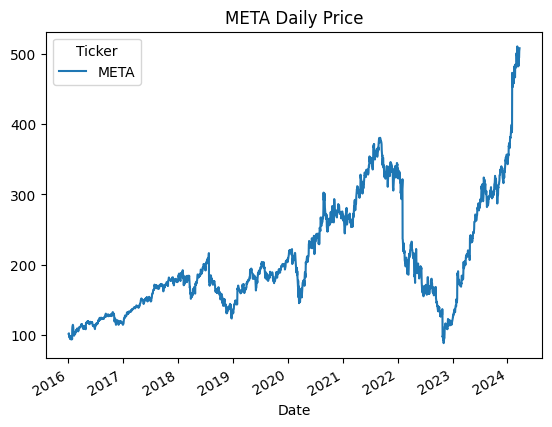

In [3]:
df.plot()
plt.title('META Daily Price')

## 1. Stationarity and Differencing

### (1) ACF Plot

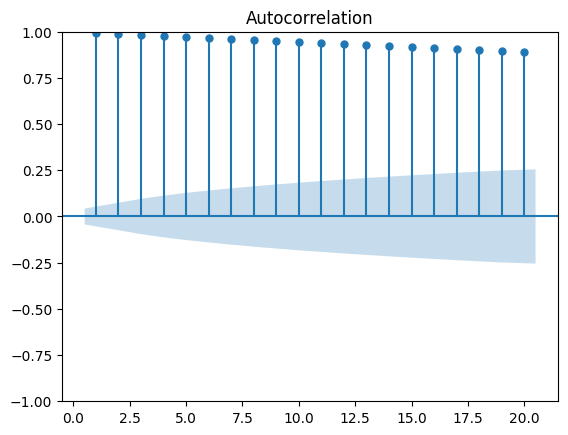

In [4]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=20, zero=False);

In [5]:
df_diff = np.log(df).diff().dropna()

<Axes: xlabel='Date'>

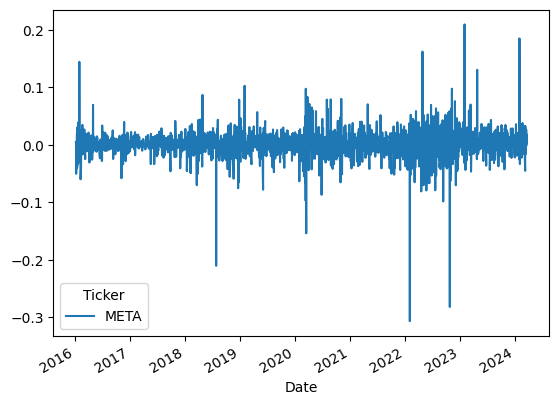

In [6]:
df_diff.plot()

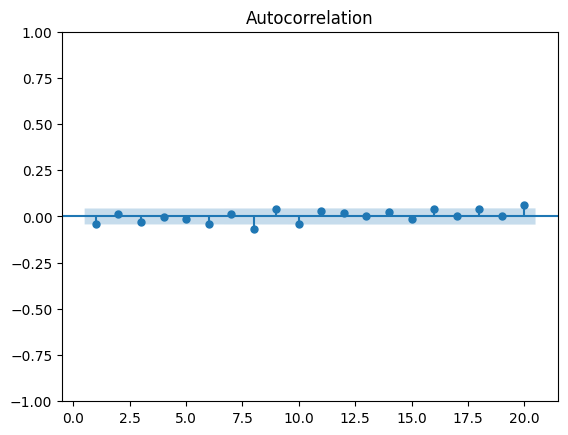

In [7]:
sm.graphics.tsa.plot_acf(df_diff.values.squeeze(), lags=20, zero=False);

### (2) ADF Test

In [8]:
from statsmodels.tsa.stattools import adfuller

print("Transformed Data")
dftest = adfuller(df_diff, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100 - int(k[:-1])))


Transformed Data
Test statistic = -47.408
P-value = 0.000
Critical values :
	1%: -3.4335176050024057 - The data is  stationary with 99% confidence
	5%: -2.862939302250063 - The data is  stationary with 95% confidence
	10%: -2.567514924515897 - The data is  stationary with 90% confidence


## 2. Use ARIMA Model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

train = np.log(df)[0:1800]
test = np.log(df)[1800:]
model = ARIMA(train, order=(1, 1, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   META   No. Observations:                 1800
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4064.918
Date:                Sat, 19 Apr 2025   AIC                          -8123.836
Time:                        20:08:44   BIC                          -8107.351
Sample:                             0   HQIC                         -8117.751
                               - 1800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8168      0.213     -3.830      0.000      -1.235      -0.399
ma.L1          0.7994      0.220      3.634      0.000       0.368       1.231
sigma2         0.0006   5.65e-06    112.925      0.0

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
index = []
for i in range(1800, 2069):
    index.append(i)
test.index=index

In [11]:
train

Ticker,META
0,4.622425
1,4.627402
2,4.629736
3,4.579449
4,4.573405
...,...
1795,5.143258
1796,5.137663
1797,5.143025
1798,5.133388


In [12]:
res.predict(start=1, end=len(train), dynamic=False)

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1       4.622425
2       4.627312
3       4.629766
4       4.580316
5       4.572819
          ...   
1796    5.143641
1797    5.137454
1798    5.143099
1799    5.133497
1800    5.128387
Name: predicted_mean, Length: 1800, dtype: float64

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'Predictions: Train Set')

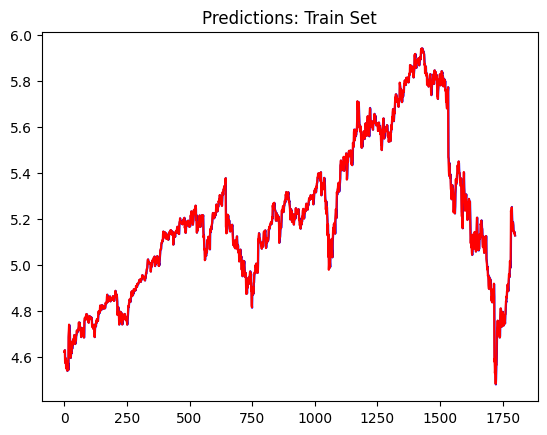

In [13]:
plt.plot(res.predict(start=1, end=len(train), dynamic=False), color='blue')
plt.plot(train, color='red')
plt.title("Predictions: Train Set")

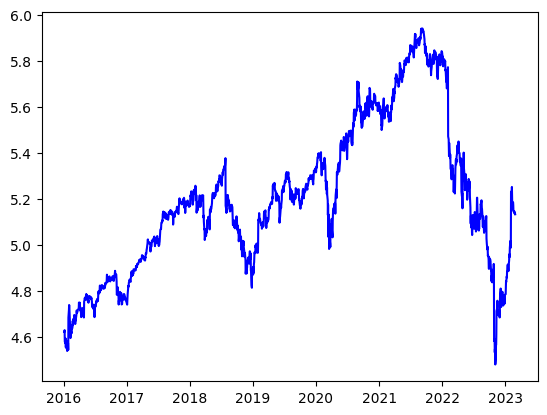

In [14]:
plt.plot(res.predict(start='2016-01-05', end='2023-02-27', dynamic=False), color='blue')

Text(0.5, 1.0, 'Residual Plot')

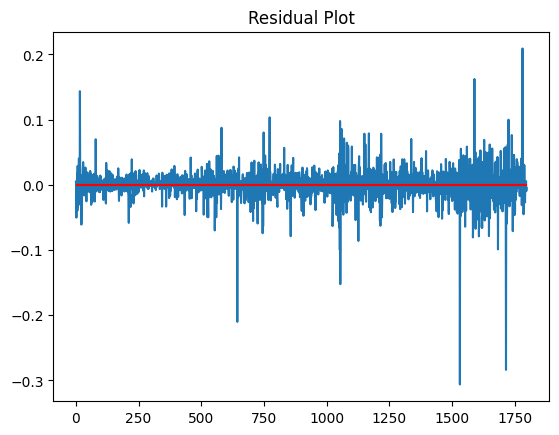

In [15]:
plt.plot(res.resid.values[1:])
plt.hlines(0, xmin=0, xmax=len(res.resid.values[1:]), color='red')
plt.title("Residual Plot")

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'Predictions: Test Set')

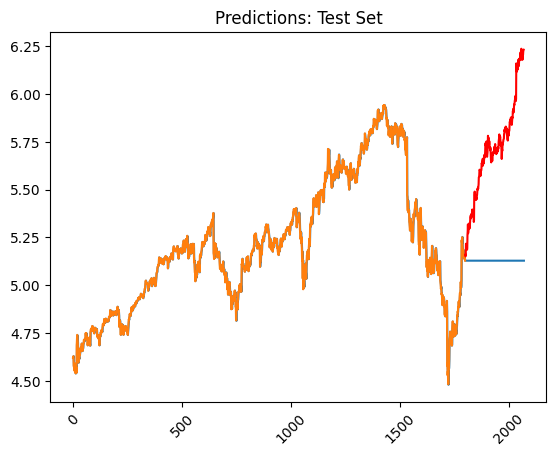

In [16]:
pred_ar = res.predict(start=1, end=len(train) + len(test), dynamic=False)
plt.plot(pred_ar)
plt.plot(train)
plt.plot(test, color='red')
plt.xticks(rotation=45)
plt.title("Predictions: Test Set")

In [18]:
predictions = pd.Series()
history = train['META'].tolist()

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions = pd.concat([predictions, pd.Series({test.index[t]:yhat})])
    obs = test['META'].iloc[t]
    history.append(obs)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25072\1248593140.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions = pd.concat([predictions, pd.Series({test.index[t]:yhat})])
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmode

(array([1750., 1800., 1850., 1900., 1950., 2000., 2050., 2100.]),
 [Text(1750.0, 0, '1750'),
  Text(1800.0, 0, '1800'),
  Text(1850.0, 0, '1850'),
  Text(1900.0, 0, '1900'),
  Text(1950.0, 0, '1950'),
  Text(2000.0, 0, '2000'),
  Text(2050.0, 0, '2050'),
  Text(2100.0, 0, '2100')])

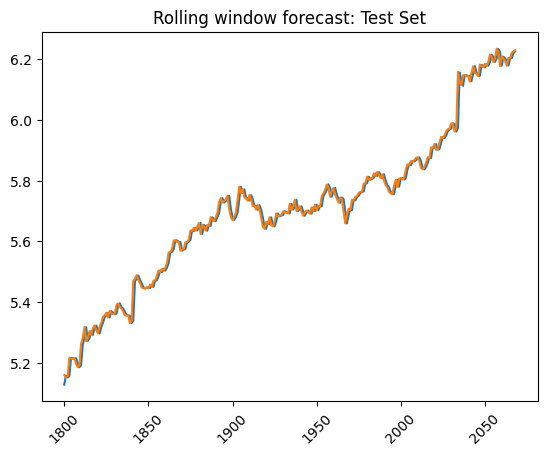

In [19]:
plt.plot(predictions)
plt.plot(test)
plt.title("Rolling window forecast: Test Set")
plt.xticks(rotation=45)

In [20]:
test-predictions

,META,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068
1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
import numpy as np
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [22]:
sigmoid(0.1*0.35+0.8*0.9)

0.6802671966986485

In [23]:
sigmoid(0.4*0.35+0.6*0.9)

0.6637386974043528

In [24]:
sigmoid(0.2723*0.68+0.873*0.662)

0.6820242299646592

In [25]:
(0.5-0.682)**2/2

0.01656200000000001

In [26]:
0.1903*(0.6903)*(1-0.6903)*0.9*0.6637*(1-0.6637)*0.9

0.00735531998322854

In [27]:
0.1-0.0009

0.09910000000000001

In [28]:
0.1903*0.6903*(1-0.6903)*0.6637

0.027001611521270095

In [29]:
24/90+12/90

0.4

In [30]:
a=np.array([125,100,70,120,60,220,75])

In [31]:
a.mean()

110.0

In [32]:
from statistics import variance
variance(a)

2975

In [33]:
b=np.array([95,85,90])

In [34]:
variance(b)

25

In [35]:
b.mean()

90.0